# CNN for RSSI + CSI

In [295]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [296]:
csi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"
rssi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/RSSI/timestamp_allignment_Balanced_2024_12_14_rtt_logs.csv"

In [297]:
# Load data CSI
reference_points = {}
spacing = 0.6  # ÊØèÈöî 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(csi_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

data, rp_labels, coord_labels = load_data(reference_points)

In [298]:
data

0           1           2           3           4           5   \
0      919.592301  929.595611  877.760787  898.203763  851.400023  893.573164   
1      698.204841  732.963846  684.079674  694.257877  651.079872  672.521375   
2      745.268408  768.188128  706.606680  713.252410  681.482208  713.950278   
3      830.278267  829.860832  804.005597  796.492310  786.787138  800.870776   
4      906.099884  903.507056  910.843565  896.688352  892.235955  875.416472   
...           ...         ...         ...         ...         ...         ...   
24495  397.615392  416.889674  395.588170  413.019370  382.733589  381.136459   
24496  643.708785  646.260010  627.624888  621.498994  605.152873  628.458431   
24497  762.685387  745.553486  706.884007  695.708272  698.951357  710.169698   
24498  401.220638  416.688133  388.561449  390.436935  370.411933  382.498366   
24499  753.160010  739.957431  724.996552  704.264865  701.806954  717.674717   

               6           7           8           9   ...        88  \
0      888.473973  871.023536  836.316328  841.770753  ... -1.387518   
1      687.674342  780.946221  803.560203  863.103702  ... -2.677159   
2      736.619983  852.877482  846.442556  880.032954  ...  0.176051   
3      791.982323  778.923616  763.872372  766.167084  ... -1.031820   
4      878.300632  854.687077  857.886939  843.664033  ... -0.445534   
...           ...         ...         ...         ...  ...       ...   
24495  393.814677  434.337426  465.842248  483.735465  ...  2.183710   
24496  617.272225  592.763865  581.986254  587.911558  ... -0.494557   
24497  720.184004  675.370269  654.120020  669.209982  ...  0.621717   
24498  394.452786  436.664631  446.643034  495.258518  ... -1.801749   
24499  715.455100  674.985185  658.325907  679.605768  ...  1.746490   

             89        90        91        92        93        94        95  \
0     -1.581549 -1.708760 -2.080869 -2.287379 -2.467120 -2.666997 -2.982241   
1     -2.877730 -3.051501  2.738820  2.503722  2.256683  2.035376  1.737005   
2     -0.063704 -0.251636 -0.776139 -1.023850 -1.275624 -1.535994 -1.899522   
3     -1.194379 -1.338067 -1.666445 -1.878363 -2.100073 -2.369892 -2.666982   
4     -0.593750 -0.783166 -1.090942 -1.286103 -1.497279 -1.784787 -2.076610   
...         ...       ...       ...       ...       ...       ...       ...   
24495  2.005190  1.826107  1.364322  1.150287  0.872978  0.573063  0.255977   
24496 -0.782703 -1.053078 -1.631902 -1.969954 -2.328378 -2.758960  3.087458   
24497  0.498336  0.356470 -0.131807 -0.426306 -0.748795 -1.031706 -1.339351   
24498 -2.120022 -2.410138  3.138034  2.751942  2.306627  1.868269  1.432071   
24499  1.586924  1.427713  1.118018  0.870126  0.650771  0.353386  0.054227   

         96     97  
0     -50.0  136.0  
1     -49.0  148.0  
2     -50.0  224.0  
3     -51.0  136.0  
4     -50.0  136.0  
...     ...    ...  
24495 -56.0  148.0  
24496 -59.0  136.0  
24497 -58.0  136.0  
24498 -56.0  148.0  
24499 -58.0  136.0  

[24500 rows x 98 columns]

In [299]:
csi = data

In [300]:
csi["Label"] = rp_labels

In [301]:
csi

0           1           2           3           4           5  \
0      919.592301  929.595611  877.760787  898.203763  851.400023  893.573164   
1      698.204841  732.963846  684.079674  694.257877  651.079872  672.521375   
2      745.268408  768.188128  706.606680  713.252410  681.482208  713.950278   
3      830.278267  829.860832  804.005597  796.492310  786.787138  800.870776   
4      906.099884  903.507056  910.843565  896.688352  892.235955  875.416472   
...           ...         ...         ...         ...         ...         ...   
24495  397.615392  416.889674  395.588170  413.019370  382.733589  381.136459   
24496  643.708785  646.260010  627.624888  621.498994  605.152873  628.458431   
24497  762.685387  745.553486  706.884007  695.708272  698.951357  710.169698   
24498  401.220638  416.688133  388.561449  390.436935  370.411933  382.498366   
24499  753.160010  739.957431  724.996552  704.264865  701.806954  717.674717   

                6           7           8           9  ...        89  \
0      888.473973  871.023536  836.316328  841.770753  ... -1.581549   
1      687.674342  780.946221  803.560203  863.103702  ... -2.877730   
2      736.619983  852.877482  846.442556  880.032954  ... -0.063704   
3      791.982323  778.923616  763.872372  766.167084  ... -1.194379   
4      878.300632  854.687077  857.886939  843.664033  ... -0.593750   
...           ...         ...         ...         ...  ...       ...   
24495  393.814677  434.337426  465.842248  483.735465  ...  2.005190   
24496  617.272225  592.763865  581.986254  587.911558  ... -0.782703   
24497  720.184004  675.370269  654.120020  669.209982  ...  0.498336   
24498  394.452786  436.664631  446.643034  495.258518  ... -2.120022   
24499  715.455100  674.985185  658.325907  679.605768  ...  1.586924   

             90        91        92        93        94        95    96  \
0     -1.708760 -2.080869 -2.287379 -2.467120 -2.666997 -2.982241 -50.0   
1     -3.051501  2.738820  2.503722  2.256683  2.035376  1.737005 -49.0   
2     -0.251636 -0.776139 -1.023850 -1.275624 -1.535994 -1.899522 -50.0   
3     -1.338067 -1.666445 -1.878363 -2.100073 -2.369892 -2.666982 -51.0   
4     -0.783166 -1.090942 -1.286103 -1.497279 -1.784787 -2.076610 -50.0   
...         ...       ...       ...       ...       ...       ...   ...   
24495  1.826107  1.364322  1.150287  0.872978  0.573063  0.255977 -56.0   
24496 -1.053078 -1.631902 -1.969954 -2.328378 -2.758960  3.087458 -59.0   
24497  0.356470 -0.131807 -0.426306 -0.748795 -1.031706 -1.339351 -58.0   
24498 -2.410138  3.138034  2.751942  2.306627  1.868269  1.432071 -56.0   
24499  1.427713  1.118018  0.870126  0.650771  0.353386  0.054227 -58.0   

          97  Label  
0      136.0      1  
1      148.0      1  
2      224.0      1  
3      136.0      1  
4      136.0      1  
...      ...    ...  
24495  148.0     49  
24496  136.0     49  
24497  136.0     49  
24498  148.0     49  
24499  136.0     49  

[24500 rows x 99 columns]

In [302]:
# Load data RSSI

label_to_coordinates_swapped = {
    "1-1":  (0, 0),   "1-2":  (0, 0.6),   "1-3":  (0, 1.2),   "1-4":  (0, 1.8),
    "1-5":  (0, 2.4), "1-6":  (0, 3.0),   "1-7":  (0, 3.6),   "1-8":  (0, 4.2),
    "1-9":  (0, 4.8), "1-10": (0, 5.4),   "1-11": (0, 6.0),

    "2-1":  (0.6, 0),  "2-11": (0.6, 6.0),

    "3-1":  (1.2, 0),  "3-11": (1.2, 6.0),

    "4-1":  (1.8, 0),  "4-11": (1.8, 6.0),

    "5-1":  (2.4, 0),  "5-11": (2.4, 6.0),

    "6-1":  (3.0, 0),  "6-2":  (3.0, 0.6),  "6-3":  (3.0, 1.2),  "6-4":  (3.0, 1.8),
    "6-5":  (3.0, 2.4), "6-6":  (3.0, 3.0),  "6-7":  (3.0, 3.6),  "6-8":  (3.0, 4.2),
    "6-9":  (3.0, 4.8), "6-10": (3.0, 5.4),  "6-11": (3.0, 6.0),

    "7-1":  (3.6, 0),  "7-11": (3.6, 6.0),

    "8-1":  (4.2, 0),  "8-11": (4.2, 6.0),

    "9-1":  (4.8, 0),  "9-11": (4.8, 6.0),

    "10-1": (5.4, 0),  "10-11": (5.4, 6.0),

    "11-1": (6.0, 0),  "11-2": (6.0, 0.6), "11-3": (6.0, 1.2), "11-4": (6.0, 1.8),
    "11-5": (6.0, 2.4),"11-6": (6.0, 3.0), "11-7": (6.0, 3.6), "11-8": (6.0, 4.2),
    "11-9": (6.0, 4.8),"11-10":(6.0, 5.4), "11-11":(6.0, 6.0)
}


coordinates = {
        1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
        36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
        2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
        6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
        12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
        16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
        20: (5.4, 6.0), 21: (6.0, 6.0),
        22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
        26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
        41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
        44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
        47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
    }
coordinate_to_label2 = {value: key for key, value in coordinates.items()}

# label_to_coordinates:  "1-1" -> (0, 0)
# coordinates:          1      -> (0, 0)

# 1) ÂÖàÂª∫Á´ã‰∏ÄÂÄã„ÄåÂ∫ßÊ®ô -> Êï∏Â≠ó„ÄçÁöÑÂèçËΩâÂ≠óÂÖ∏
coord_to_num = {value: key for key, value in coordinates.items()}
# coord_to_num[(0,0)] = 1,  coord_to_num[(0.6,0)] = 40, ...

# 2) Âª∫Á´ã "1-1" -> Êï¥Êï∏Ê®ôÁ±§ ÁöÑ map
label_str_to_num = {}
for str_label, coord in label_to_coordinates_swapped.items():
    if coord in coord_to_num:  # Á¢∫‰øùÂú®Â∫ßÊ®ôÂ≠óÂÖ∏‰∏≠ÊâæÂæóÂà∞
        label_str_to_num[str_label] = coord_to_num[coord]

In [303]:
rssi = pd.read_csv(rssi_path)

rssi = rssi.drop(columns=['timeStemp', 'AP1_Distance (mm)', 'AP2_Distance (mm)', 'AP3_Distance (mm)', 'AP4_Distance (mm)', 'AP1_StdDev (mm)','AP2_StdDev (mm)', 'AP3_StdDev (mm)', 'AP4_StdDev (mm)'])

In [304]:
rssi["Label"]

0        1-11
1        1-11
2        1-11
3        1-11
4        1-11
         ... 
19644     7-1
19645     7-1
19646     7-1
19647     7-1
19648     7-1
Name: Label, Length: 19649, dtype: object

In [305]:
rssi["Label"] = (
    rssi["Label"]
    .map(label_to_coordinates_swapped)   # Áî± "1-1" ‚Üí (0,0)
    .map(coordinate_to_label2)   # Áî± (0,0) ‚Üí 1 (ÊàñÂÖ∂‰ªñÊï¥Êï∏Ê®ôÁ±§)
)


In [306]:
rssi

Label  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi
0         11     -60.0     -68.0     -61.0     -59.0
1         11     -62.0     -70.0     -59.0     -59.0
2         11     -61.0     -69.0     -62.0     -55.0
3         11     -62.0     -69.0     -63.0     -55.0
4         11     -61.0     -70.0     -62.0     -55.0
...      ...       ...       ...       ...       ...
19644     35     -64.0     -66.0     -61.0     -58.0
19645     35     -67.0     -75.0     -62.0     -59.0
19646     35     -64.0     -66.0     -61.0     -57.0
19647     35     -66.0     -65.0     -59.0     -58.0
19648     35     -68.0     -64.0     -61.0     -59.0

[19649 rows x 5 columns]

In [307]:
import pandas as pd

# ÂÅáË®≠‰Ω†ÁöÑ RSSI DataFrame ÂêçÂè´ df_rssi
# ÂÆÉËá≥Â∞ëÂåÖÂê´Ê¨Ñ‰Ωç ["Label", "AP1_Rssi", "AP2_Rssi", ...] Á≠âË≥áË®ä

target_total = 500  # ÊØèÂÄã Label ÊúüÊúõÊìÅÊúâÁöÑÁ≠ÜÊï∏
need_extra = 99     # ÈúÄË¶ÅÂÜçÊäΩÂπæÁ≠Ü (500 - 401 = 99)

all_label_groups = []  # Áî®‰æÜÂ≠òÊîæÊØèÂÄã label Êì¥ÂÖÖÂæåÁöÑ DataFrame

unique_labels = rssi["Label"].unique()

for label_value in unique_labels:
    sub_df = rssi[rssi["Label"] == label_value].reset_index(drop=True)
    
    # ÂÅáË®≠ÈÄôË£°Â∑≤Áü• sub_df Èï∑Â∫¶Â∞±ÊòØ 401ÔºõËã•ÊúâÈúÄË¶ÅÔºå‰Ω†ÂèØÂä†Ê™¢Êü•:
    # if len(sub_df) != 401:
    #     print(f"Label {label_value} ‰∏çÁ≠âÊñº 401 Á≠ÜÔºåÁõÆÂâçÊúâ {len(sub_df)} Á≠Ü„ÄÇ")
    #     # ÊàñË¶ñÈúÄÊ±ÇÂÅöÂà•ÁöÑËôïÁêÜ

    # Âæû sub_df ÂÜçÊäΩÊ®£ 99 Á≠Ü (ÊúâÊîæÂõû replace=True)
    extra = sub_df.sample(n=need_extra, replace=True)
    
    # ËàáÂéü sub_df Âêà‰Ωµ
    expanded_sub_df = pd.concat([sub_df, extra], ignore_index=True)
    
    # Ê≠§ÊôÇ expanded_sub_df Â∞±Êúâ 401 + 99 = 500 Á≠Ü
    all_label_groups.append(expanded_sub_df)

# ÊúÄÂæåÂ∞áÊâÄÊúâ label Êì¥ÂÖÖÂæåÁöÑ DataFrame Âêà‰Ωµ
df_final = pd.concat(all_label_groups, ignore_index=True)

print(df_final.shape)  # ÊáâË©≤ÊòØ (500 * label_count, ...)
print(df_final["Label"].value_counts())  # Ê™¢Êü•ÊØèÂÄã Label Á≠ÜÊï∏ÊòØÂê¶ÈÉΩ 500


(24500, 5)
Label
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
1     500
40    500
39    500
38    500
37    500
36    500
41    500
42    500
43    500
44    500
45    500
46    500
47    500
48    500
49    500
16    500
15    500
14    500
13    500
12    500
17    500
18    500
19    500
20    500
21    500
22    500
23    500
24    500
25    500
26    500
27    500
28    500
29    500
30    500
31    500
32    500
33    500
34    500
35    500
Name: count, dtype: int64


In [308]:
labels_rssi = df_final["Label"].unique()
labels_other = csi["Label"].unique()

print("df_rssi labels:", labels_rssi)
print("df_other labels:", labels_other)


print("df_rssi labels len:", len(labels_rssi))
print("df_other labels len:", len(labels_other))

common_labels = sorted(set(labels_rssi).intersection(labels_other))

for lb in common_labels:
    count_rssi = len(rssi[rssi["Label"] == lb])
    count_other = len(csi[csi["Label"] == lb])
    #if count_rssi == 0 or count_other == 0:
    print(f"Label={lb}, df_rssi count={count_rssi}, df_other count={count_other}")


df_rssi labels: [11 10  9  8  7  6  5  4  3  2  1 40 39 38 37 36 41 42 43 44 45 46 47 48
 49 16 15 14 13 12 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35]
df_other labels: [ 1 40 39 38 37 36 35 34 33 32 31  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 41 42 43 44 45 46 47 48
 49]
df_rssi labels len: 49
df_other labels len: 49
Label=1, df_rssi count=401, df_other count=500
Label=2, df_rssi count=401, df_other count=500
Label=3, df_rssi count=401, df_other count=500
Label=4, df_rssi count=401, df_other count=500
Label=5, df_rssi count=401, df_other count=500
Label=6, df_rssi count=401, df_other count=500
Label=7, df_rssi count=401, df_other count=500
Label=8, df_rssi count=401, df_other count=500
Label=9, df_rssi count=401, df_other count=500
Label=10, df_rssi count=401, df_other count=500
Label=11, df_rssi count=401, df_other count=500
Label=12, df_rssi count=401, df_other count=500
Label=13, df_rssi count=401, df_other count=500
Lab

In [309]:
import pandas as pd

# === ÂÅáË®≠‰ª•‰∏ãÂÖ©ÂÄã DataFrame Â∑≤Á∂ìÂ∞±Á∑í ===
# df_rssi: ÂåÖÂê´ ["Label", ...] + RSSI Ê¨Ñ‰Ωç
# df_csi:  ÂåÖÂê´ ["Label", ...] + CSI Ê¨Ñ‰Ωç

# ÂèñÂæóÂÖ©ÈÇäÈÉΩÂá∫ÁèæÁöÑÊâÄÊúâ Label
common_labels = sorted(set(df_final["Label"].unique()) & set(csi["Label"].unique()))

merged_list = []

for lb in common_labels:
    # 1. ÂèñÂá∫Ë©≤ Label ÁöÑÂ≠êÈõÜ
    sub_rssi = df_final[df_final["Label"] == lb].reset_index(drop=True)
    sub_csi  = csi[csi["Label"] == lb].reset_index(drop=True)
    
    # 2. Ê™¢Êü•ÂÖ©ËÄÖÈï∑Â∫¶ÊòØÂê¶‰∏ÄËá¥
    len_rssi = len(sub_rssi)
    len_csi  = len(sub_csi)
    
    if len_rssi != len_csi:
        print(f"Ë≠¶ÂëäÔºöLabel={lb} Âú® df_rssi Êúâ {len_rssi} Á≠Ü, df_csi Êúâ {len_csi} Á≠ÜÔºåÈï∑Â∫¶‰∏çÂêå„ÄÇ")
        # ‰Ω†ÂèØ‰ª•ÈÅ∏ÊìáÔºöÁï•ÈÅé„ÄÅÊàñÂÉÖÂèñÊúÄÁü≠Èï∑Â∫¶„ÄÅÊàñË£úÈΩä‚Ä¶
        # ÈÄôÈÇäÁ§∫ÁØÑ„ÄåÂèñÊúÄÂ∞èÈï∑Â∫¶„Äç‰æÜÂ∞çÈΩä
        min_len = min(len_rssi, len_csi)
        sub_rssi = sub_rssi.iloc[:min_len].reset_index(drop=True)
        sub_csi  = sub_csi.iloc[:min_len].reset_index(drop=True)
    
    # 3. ÈÄêÂàó„ÄåË≤ºÂêà„ÄçÂÖ©ÂÄãÂ≠ê DataFrame (axis=1 Âç≥Â∑¶Âè≥Âêà‰Ωµ)
    #    Â¶ÇÊûú‰∏çÊÉ≥ÁïôÈáçË§áÁöÑ Label Ê¨Ñ‰ΩçÔºåÂèØ‰ª•ÂÖà‰∏üÊéâ sub_csi ÁöÑ Label Ê¨Ñ‰Ωç
    sub_csi_dropped = sub_csi.drop(columns=["Label"])
    
    # Âêà‰Ωµ
    sub_merged = pd.concat([sub_rssi, sub_csi_dropped], axis=1)
    
    # 4. ÊääÂêà‰ΩµÂæåÁöÑÂ≠ê DataFrame ÊîæÈÄ≤Ê∏ÖÂñÆ
    merged_list.append(sub_merged)

# 5. ÊúÄÂæåÊääÊâÄÊúâ Label ÁöÑÁµêÊûú‰∏ä‰∏ãÂ†ÜËµ∑‰æÜ
df_merged_all = pd.concat(merged_list, ignore_index=True)

# Ê™¢Êü•
print(df_merged_all.shape)
print(df_merged_all.head())




 

(24500, 103)
   Label  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi           0           1  \
0      1     -62.0     -72.0     -65.0     -54.0  919.592301  929.595611   
1      1     -61.0     -73.0     -66.0     -56.0  698.204841  732.963846   
2      1     -62.0     -72.0     -66.0     -55.0  745.268408  768.188128   
3      1     -61.0     -73.0     -66.0     -55.0  830.278267  829.860832   
4      1     -54.0     -72.0     -67.0     -55.0  906.099884  903.507056   

            2           3           4  ...        88        89        90  \
0  877.760787  898.203763  851.400023  ... -1.387518 -1.581549 -1.708760   
1  684.079674  694.257877  651.079872  ... -2.677159 -2.877730 -3.051501   
2  706.606680  713.252410  681.482208  ...  0.176051 -0.063704 -0.251636   
3  804.005597  796.492310  786.787138  ... -1.031820 -1.194379 -1.338067   
4  910.843565  896.688352  892.235955  ... -0.445534 -0.593750 -0.783166   

         91        92        93        94        95    96     97  
0 -2.0

In [310]:
df_merged_all

Label  AP1_Rssi  AP2_Rssi  AP3_Rssi  AP4_Rssi           0           1  \
0          1     -62.0     -72.0     -65.0     -54.0  919.592301  929.595611   
1          1     -61.0     -73.0     -66.0     -56.0  698.204841  732.963846   
2          1     -62.0     -72.0     -66.0     -55.0  745.268408  768.188128   
3          1     -61.0     -73.0     -66.0     -55.0  830.278267  829.860832   
4          1     -54.0     -72.0     -67.0     -55.0  906.099884  903.507056   
...      ...       ...       ...       ...       ...         ...         ...   
24495     49     -53.0     -64.0     -56.0     -59.0  397.615392  416.889674   
24496     49     -54.0     -64.0     -56.0     -58.0  643.708785  646.260010   
24497     49     -54.0     -64.0     -55.0     -59.0  762.685387  745.553486   
24498     49     -53.0     -64.0     -53.0     -57.0  401.220638  416.688133   
24499     49     -54.0     -64.0     -55.0     -59.0  753.160010  739.957431   

                2           3           4  ...        88        89        90  \
0      877.760787  898.203763  851.400023  ... -1.387518 -1.581549 -1.708760   
1      684.079674  694.257877  651.079872  ... -2.677159 -2.877730 -3.051501   
2      706.606680  713.252410  681.482208  ...  0.176051 -0.063704 -0.251636   
3      804.005597  796.492310  786.787138  ... -1.031820 -1.194379 -1.338067   
4      910.843565  896.688352  892.235955  ... -0.445534 -0.593750 -0.783166   
...           ...         ...         ...  ...       ...       ...       ...   
24495  395.588170  413.019370  382.733589  ...  2.183710  2.005190  1.826107   
24496  627.624888  621.498994  605.152873  ... -0.494557 -0.782703 -1.053078   
24497  706.884007  695.708272  698.951357  ...  0.621717  0.498336  0.356470   
24498  388.561449  390.436935  370.411933  ... -1.801749 -2.120022 -2.410138   
24499  724.996552  704.264865  701.806954  ...  1.746490  1.586924  1.427713   

             91        92        93        94        95    96     97  
0     -2.080869 -2.287379 -2.467120 -2.666997 -2.982241 -50.0  136.0  
1      2.738820  2.503722  2.256683  2.035376  1.737005 -49.0  148.0  
2     -0.776139 -1.023850 -1.275624 -1.535994 -1.899522 -50.0  224.0  
3     -1.666445 -1.878363 -2.100073 -2.369892 -2.666982 -51.0  136.0  
4     -1.090942 -1.286103 -1.497279 -1.784787 -2.076610 -50.0  136.0  
...         ...       ...       ...       ...       ...   ...    ...  
24495  1.364322  1.150287  0.872978  0.573063  0.255977 -56.0  148.0  
24496 -1.631902 -1.969954 -2.328378 -2.758960  3.087458 -59.0  136.0  
24497 -0.131807 -0.426306 -0.748795 -1.031706 -1.339351 -58.0  136.0  
24498  3.138034  2.751942  2.306627  1.868269  1.432071 -56.0  148.0  
24499  1.118018  0.870126  0.650771  0.353386  0.054227 -58.0  136.0  

[24500 rows x 103 columns]

In [311]:
rssi_columns = ['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']
df_merged_all[rssi_columns] = df_merged_all[rssi_columns].fillna(0)


## Data Generator

In [312]:
rp_labels = df_merged_all['Label']
csi = df_merged_all.drop(columns=['Label', 'AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi'])
amp = csi.iloc[:,:48]
phase = csi.iloc[:,48:-2]
rssi = df_merged_all[['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']]

In [313]:
type(amp)

pandas.core.frame.DataFrame

In [314]:
amp_d = denoise.preprocess_csi_for_fingerprint2(np.array(amp)) # ÂâçËôïÁêÜ

In [315]:
amp_d = pd.DataFrame(amp_d)

In [316]:
from sklearn.model_selection import train_test_split

# ÂèñÂæóÂéüÂßãÁöÑ index
indices = amp_d.index

# ÂÖàÂàáÂàÜ train Ëàá temp (train: 70%, temp: 30%)
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)

# Êé•ËëóÂàáÂàÜ temp ÁÇ∫ validation Ëàá test (ÂêÑ 10% Ëàá 20%ÔºåÂõ†ÁÇ∫ 1/3 ÁöÑ 30% ÁÇ∫ 10%)
val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, random_state=42)

# ‰ΩøÁî® .loc Ê†πÊìöÂàáÂàÜÁöÑ index ÂèñÂæóÂêÑÈÉ®ÂàÜË≥áÊñô
amp_train = amp_d.loc[train_idx]
amp_val   = amp_d.loc[val_idx]
amp_test  = amp_d.loc[test_idx]

rssi_train = rssi.loc[train_idx]
rssi_val   = rssi.loc[val_idx]
rssi_test  = rssi.loc[test_idx]

# ÂÅáË®≠ one_hot_labels ‰πüÊòØËàá amp Âêå index ÁöÑ Series Êàñ DataFrame
y_train = rp_labels.loc[train_idx]
y_val   = rp_labels.loc[val_idx]
y_test  = rp_labels.loc[test_idx]


In [318]:
print("amp_train shape:", amp_train.shape)


amp_train shape: (17150, 48)


In [319]:
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_oh = encoder.fit_transform(np.array(y_val).reshape(-1, 1))
y_test_oh = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

In [320]:
print("y_train_oh shape:", y_train_oh.shape)
print("y_val_oh shape:", y_val_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

y_train_oh shape: (17150, 49)
y_val_oh shape: (4900, 49)
y_test_oh shape: (2450, 49)


In [321]:
# ÂâµÂª∫ Dataset Âíå DataLoader

batch_size = 32

train_dataset = CSIRSSIDataset(np.array(amp_train), np.array(rssi_train), y_train_oh)
val_dataset = CSIRSSIDataset(np.array(amp_val),np.array(rssi_val), y_val_oh)
test_dataset = CSIRSSIDataset(np.array(amp_test), np.array(rssi_test), y_test_oh)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [322]:
for amp_inputs, rssi_inputs, labels in train_loader:
        print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...

In [267]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CSIRSSIClassifier(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSIClassifier, self).__init__()
        # ========= CSI ÂàÜÊîØ =========
        # ÂèÉÁÖß‰Ω†ÂéüÊú¨ÁöÑ CSI CNN Êû∂Êßã (Ëº∏ÂÖ• shape: (batch, 1, 48))
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Ëº∏ÂÖ•Èï∑Â∫¶ 48 Á∂ìÈÅéÂÖ©Ê¨° pool ÂæåËÆä 48/2 -> 24ÔºåÂÜç 24/2 -> 12
        # Ëº∏Âá∫ channels = 128, ÊïÖ flatten_dim = 128 * 12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        # ÊúÄÂæå CSI ÁâπÂæµÁ∂≠Â∫¶ÁÇ∫ 64
        
        # ========= RSSI ÂàÜÊîØ =========
        # ÈáùÂ∞ç RSSI Ëº∏ÂÖ• (ÂÅáË®≠Á∂≠Â∫¶ÁÇ∫ rssi_dim, Â¶Ç 4)
        self.fc_rssi1 = nn.Linear(rssi_dim, 32)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(32, 32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # ÊúÄÂæå RSSI ÁâπÂæµÁ∂≠Â∫¶ÁÇ∫ 32
        
        # ========= ËûçÂêàÂæåÂàÜÈ°û =========
        # Â∞á CSI (64-d) Ëàá RSSI (32-d) ËûçÂêàÂæåÁÇ∫ 96-dÔºåÂÜçÊé•ÂÖ®ÈÄ£Êé•Â±§
        self.fc_merge1 = nn.Linear(64 + 32, 64)
        self.dropout_merge = nn.Dropout(0.5)
        self.fc_merge2 = nn.Linear(64, num_classes)
    
    def forward(self, csi_input, rssi_input):
        # ---- CSI ÂàÜÊîØ ----
        # csi_input È†êÊúü shape ÁÇ∫ (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten Êàê (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # ---- RSSI ÂàÜÊîØ ----
        # rssi_input È†êÊúü shape ÁÇ∫ (batch, rssi_dim)
        rssi_feat = F.relu(self.fc_rssi1(rssi_input))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.fc_rssi2(rssi_feat))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # ---- ËûçÂêàÁâπÂæµ ----
        # Â∞á CSI Ëàá RSSI ÁâπÂæµÂú®ÁâπÂæµÁ∂≠Â∫¶‰∏äÂÅö concat (dim=1)
        fusion = torch.cat((csi_feat, rssi_feat), dim=1)
        fusion = F.relu(self.fc_merge1(fusion))
        fusion = self.dropout_merge(fusion)
        out = self.fc_merge2(fusion)
        return out

# ÂàùÂßãÂåñÊ®°Âûã
model = CSIRSSIClassifier(num_classes=49, rssi_dim=4).to(device)

# Ê∏¨Ë©¶ÔºöÂª∫Á´ã dummy Ëº∏ÂÖ•‰∏¶ÂÅöÂâçÂêëÂÇ≥Êí≠
dummy_csi = torch.randn(1, 1, 48).to(device)  # CSI Ëº∏ÂÖ•: (batch=1, channels=1, length=48)
dummy_rssi = torch.randn(1, 4).to(device)       # RSSI Ëº∏ÂÖ•: (batch=1, 4-d)
output = model(dummy_csi, dummy_rssi)
print("Output shape:", output.shape)  # È†êÊúü: (1, 49)

# ÂÆâË£ù torchinfo (Â¶ÇÊûúÈÇÑÊ≤íÂÆâË£ù)
# pip install torchinfo

from torchinfo import summary

dummy_csi = torch.randn(1, 1, 48).to(device)
dummy_rssi = torch.randn(1, 4).to(device)
summary(model, input_data=(dummy_csi, dummy_rssi))


Using device: cuda
Output shape: torch.Size([1, 49])


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSIClassifier                        [1, 49]                   --
‚îú‚îÄConv1d: 1-1                            [1, 64, 48]               256
‚îú‚îÄBatchNorm1d: 1-2                       [1, 64, 48]               128
‚îú‚îÄMaxPool1d: 1-3                         [1, 64, 24]               --
‚îú‚îÄConv1d: 1-4                            [1, 128, 24]              24,704
‚îú‚îÄBatchNorm1d: 1-5                       [1, 128, 24]              256
‚îú‚îÄMaxPool1d: 1-6                         [1, 128, 12]              --
‚îú‚îÄLinear: 1-7                            [1, 128]                  196,736
‚îú‚îÄDropout: 1-8                           [1, 128]                  --
‚îú‚îÄLinear: 1-9                            [1, 64]                   8,256
‚îú‚îÄDropout: 1-10                          [1, 64]                   --
‚îú‚îÄLinear: 1-11                           [1, 32]                   160
‚îú‚îÄDropout: 1-12      

In [41]:
import torch.nn as nn
import torch.optim as optim

# ÊêçÂ§±ÂáΩÊï∏
criterion = nn.CrossEntropyLoss()

# ÂÑ™ÂåñÂô®
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Â≠∏ÁøíÁéáË™øÊï¥Âô®
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import torch
import matplotlib.pyplot as plt

# ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°ÂûãÁõ∏ÈóúË®≠ÂÆö
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_best_model_0316_std.pth"

# Ë®ìÁ∑¥ÂèÉÊï∏
epochs = 200

# Early Stopping ÂèÉÊï∏
patience = 20
counter = 0  

# Á¥ÄÈåÑË®ìÁ∑¥ÈÅéÁ®ã‰∏≠ÁöÑ loss Âíå accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ---- Ë®ìÁ∑¥ÈöéÊÆµ ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # Ê≥®ÊÑèÔºöÈÄôË£°ÊØèÂÄã batch ËøîÂõû‰∏âÂÄãÈ†ÖÁõÆÔºöCSI (amp)„ÄÅRSSI Ëàá labels
    for amp_inputs, rssi_inputs, labels in train_loader:
        # Â∞áË≥áÊñôÁßªÂà∞ device ‰∏ä
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # ÂÇ≥ÂÖ•ÂÖ©ÂÄãËº∏ÂÖ•Âà∞Ê®°Âûã (CSI Ëàá RSSI)
        outputs = model(amp_inputs, rssi_inputs)
        
        # CrossEntropyLoss ÈúÄË¶Å target ÁÇ∫ class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        
        # Êõ¥Êñ∞Ë®ìÁ∑¥ loss ËàáÊ≠£Á¢∫Êï∏
        train_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ---- È©óË≠âÈöéÊÆµ ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(amp_inputs, rssi_inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            
            val_loss += loss.item() * amp_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    # Á¥ÄÈåÑÊØèÂÄã epoch ÁöÑÊï∏ÂÄº
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Ëº∏Âá∫Áï∂Ââç epoch ÁöÑÁµêÊûú
    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: {best_val_loss:.4f}) Ëá≥ {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


Epoch [1/200] | Train Loss: 3.9500 | Train Acc: 2.70% | Val Loss: 3.3329 | Val Acc: 9.06%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 3.3329) Ëá≥ ./models_save/rssi_csi_best_model_0316_std.pth
Epoch [2/200] | Train Loss: 3.1523 | Train Acc: 9.13% | Val Loss: 2.3383 | Val Acc: 27.10%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 2.3383) Ëá≥ ./models_save/rssi_csi_best_model_0316_std.pth
Epoch [3/200] | Train Loss: 2.5662 | Train Acc: 17.03% | Val Loss: 1.8481 | Val Acc: 33.96%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 1.8481) Ëá≥ ./models_save/rssi_csi_best_model_0316_std.pth
Epoch [4/200] | Train Loss: 2.1881 | Train Acc: 25.25% | Val Loss: 1.4929 | Val Acc: 51.47%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 1.4929) Ëá≥ ./models_save/rssi_csi_best_model_0316_std.pth
Epoch [5/200] | Train Loss: 1.9160 | Train Acc: 33.49% | Val Loss: 1.1878 | Val Acc: 64.80%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 1.1878) Ëá≥ ./models_save/rssi_csi_best_model_0316_std.pth
Epoch [6/200] | Train Loss: 1.6630 | Train Acc: 42.34% | Val Loss: 0.8420 | Va

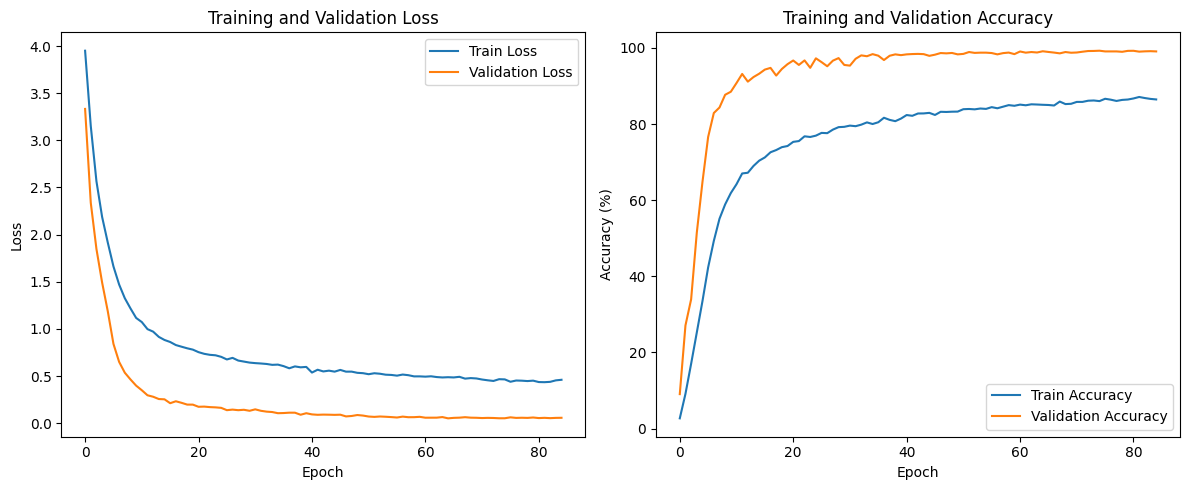

In [43]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [268]:
# ËºâÂÖ•ÊúÄ‰Ω≥Ê®°Âûã
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_best_model_0316_std.pth"))
model.eval()

# Ê∏¨Ë©¶Ê®°Âûã
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # ÂÑ≤Â≠òÁúüÂØ¶Ê®ôÁ±§ËàáÈ†êÊ∏¨Ê®ôÁ±§
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"üìä Ê∏¨Ë©¶ÊêçÂ§±: {test_loss:.4f}, Ê∏¨Ë©¶Ê∫ñÁ¢∫Áéá: {accuracy:.2f}%")

üìä Ê∏¨Ë©¶ÊêçÂ§±: 0.1261, Ê∏¨Ë©¶Ê∫ñÁ¢∫Áéá: 99.22%


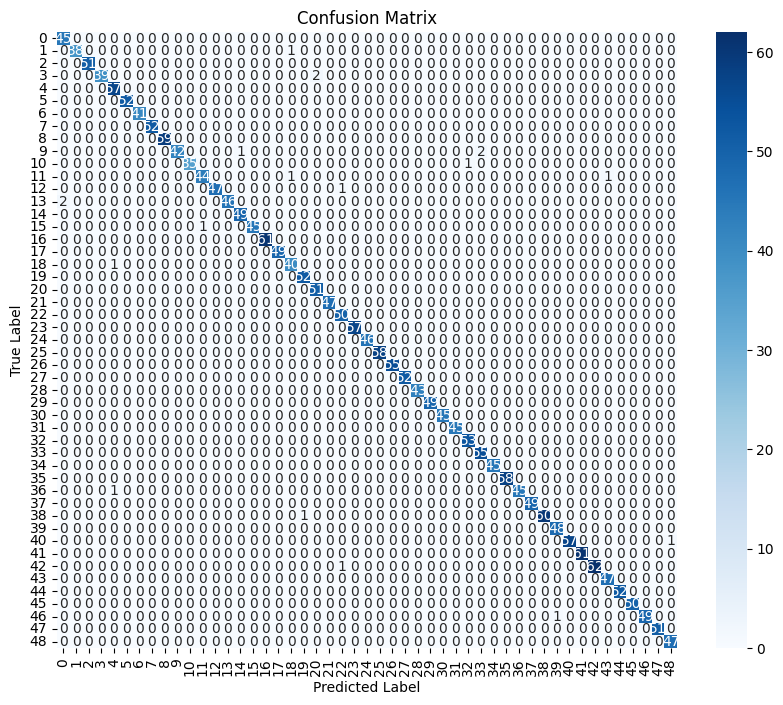

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ë®àÁÆó Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Áï´Âá∫ Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(49), yticklabels=range(49))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [269]:
import numpy as np

def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂàÜÂà•Â≠òÊîæÁúüÂØ¶ÂíåÈ†êÊ∏¨ÁöÑ labelÔºàÊï¥Êï∏Ôºâ
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # ÂèñÂá∫Â∞çÊáâÁöÑÂ∫ßÊ®ô
        if true_label not in coordinates or pred_label not in coordinates:
            # Ëã•ÊüêÂÄã label ‰∏çÂú®Â∫ßÊ®ôÂ≠óÂÖ∏ÂÖßÔºåÂ∞±Ë∑≥ÈÅéÔºàÊàñË¶ñÈúÄÊ±ÇËôïÁêÜÔºâ
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # Ë®àÁÆóÊ≠êÊ∞èË∑ùÈõ¢
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

COORDINATES = {
    # ‰∏ãÈÇäÁïå (1-10 Âíå 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),

    # Â∑¶ÈÇäÁïå (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),

    # ‰∏äÈÇäÁïå (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),

    # Âè≥ÈÇäÁïå (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),

    # ‰∏≠ÈñìÈªû (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

mean_error = compute_mean_distance_error(all_labels, all_predictions, COORDINATES)
print("Mean distance error:", mean_error)


Mean distance error: 0.03872008323140744


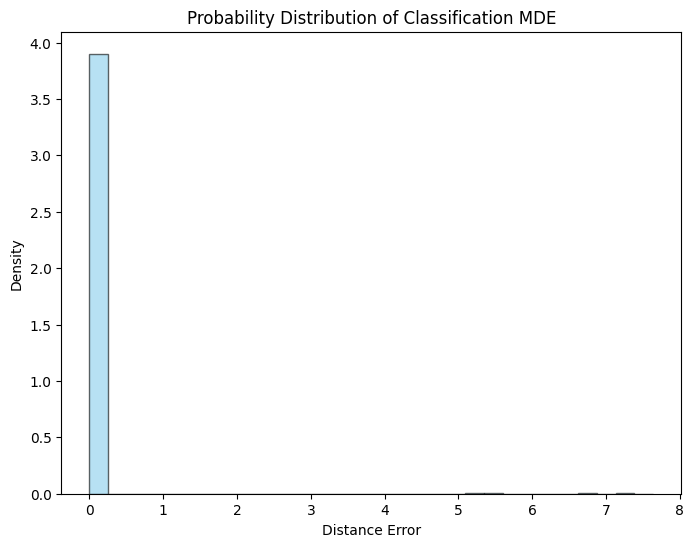

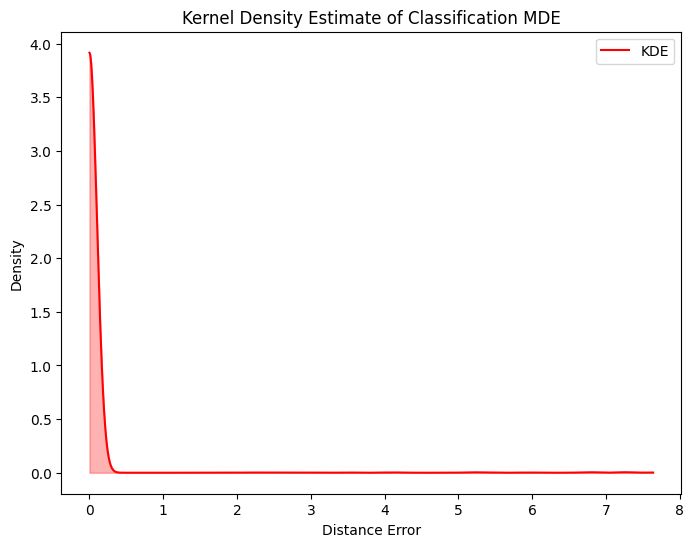

In [270]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_individual_errors_cls(y_true, y_pred, coordinates):
    """
    y_true, y_pred: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂàÜÂà•Â≠òÊîæÁúüÂØ¶ÂíåÈ†êÊ∏¨ÁöÑ labelÔºàÊï¥Êï∏Ôºâ
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # Ëã•ÊüêÂÄãÊ®ôÁ±§‰∏çÂú®Â≠óÂÖ∏‰∏≠ÔºåÂ∞±Ë∑≥ÈÅé
        if true_label not in coordinates or pred_label not in coordinates:
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.array(errors)

# Ë®àÁÆóÊØèÁ≠ÜË≥áÊñôÁöÑË∑ùÈõ¢Ë™§Â∑Æ
errors = compute_individual_errors_cls(np.array(all_labels), np.array(all_predictions), COORDINATES)

# Áπ™Ë£ΩÁõ¥ÊñπÂúñÔºåË®≠ÁΩÆ density=True ‰ΩøÁõ¥ÊñπÂúñÊ≠∏‰∏ÄÂåñÁÇ∫Ê©üÁéáÂØÜÂ∫¶
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.xlabel("Distance Error")
plt.ylabel("Density")
plt.title("Probability Distribution of Classification MDE")
plt.show()

# ‰ΩøÁî® Gaussian KDE ‰º∞Ë®àÂØÜÂ∫¶‰∏¶Áπ™Ë£Ω
kde = gaussian_kde(errors)
x_range = np.linspace(0, errors.max(), 1000)
density = kde(x_range)

plt.figure(figsize=(8,6))
plt.plot(x_range, density, 'r-', label="KDE")
plt.fill_between(x_range, density, alpha=0.3, color='red')
plt.xlabel("Distance Error")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Classification MDE")
plt.legend()
plt.show()

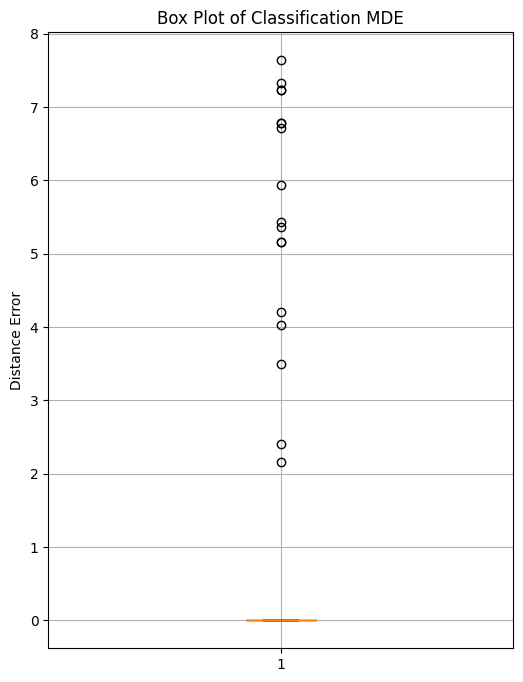

In [271]:
import numpy as np
import matplotlib.pyplot as plt

# Ë®àÁÆóÊØèÁ≠ÜË≥áÊñôÁöÑË∑ùÈõ¢Ë™§Â∑Æ
errors = compute_individual_errors_cls(np.array(all_labels), np.array(all_predictions), COORDINATES)

# Áπ™Ë£ΩÁÆ±ÂûãÂúñ
plt.figure(figsize=(6, 8))
plt.boxplot(errors, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.ylabel("Distance Error")
plt.title("Box Plot of Classification MDE")
plt.grid(True)

plt.show()

# ÈõôËº∏Âá∫

In [326]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary  # torchinfo ÂèØÁî®‰æÜÈ°ØÁ§∫Â§öËº∏ÂÖ•Ê®°ÂûãÊëòË¶Å
import matplotlib.pyplot as plt

# -----------------------
# Ê®°ÂûãÂÆöÁæ©ÔºöCSIRSSI_DualHead
# -----------------------
class CSIRSSI_DualHead(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_DualHead, self).__init__()
        # ---- CSI ÂàÜÊîØ (CNN) ---
        # ÂÅáË®≠Ëº∏ÂÖ• CSI shape ÁÇ∫ (batch, 1, 48)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Ëº∏ÂÖ•Èï∑Â∫¶ 48 ‚Üí Á∂ìÈÅéÂÖ©Ê¨° pooling ‚Üí 48/2=24ÔºåÂÜç 24/2=12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        # Ê≠§ÊôÇ CSI ÂàÜÊîØËº∏Âá∫ 64 Á∂≠ÁâπÂæµ
        
        # ---- RSSI ÂàÜÊîØ (MLP) ----
        self.fc_rssi1 = nn.Linear(rssi_dim, 32)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(32, 32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # RSSI ÂàÜÊîØËº∏Âá∫ 32 Á∂≠ÁâπÂæµ
        
        # ---- ËûçÂêàÂ±§ ----
        # Â∞á CSI (64-d) Ëàá RSSI (32-d) ÈÄ£Êé• ‚Üí 96-d
        self.fc_fusion = nn.Linear(96, 64)
        self.dropout_fusion = nn.Dropout(0.5)
        
        # ---- ÈõôËº∏Âá∫È†≠ ----
        # ÂàÜÈ°ûÈ†≠ÔºöËº∏Âá∫ num_classes ÂÄãÈ°ûÂà•ÁöÑ logits
        self.fc_class = nn.Linear(64, num_classes)
        # ÂõûÊ≠∏È†≠ÔºöËº∏Âá∫ 2 ÂÄãÊï∏ÂÄº (X, Y)
        self.fc_reg = nn.Linear(64, 2)
    
    def forward(self, csi_input, rssi_input):
        # CSI ÂàÜÊîØ
        # Â¶ÇÊûúËº∏ÂÖ•ÁÇ∫ (batch, 48)ÔºåÂâáÊì¥Â±ïÊàê (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # flatten ‚Üí (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # RSSI ÂàÜÊîØ
        rssi_feat = F.relu(self.fc_rssi1(rssi_input))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.fc_rssi2(rssi_feat))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # ËûçÂêàÁâπÂæµ
        fusion = torch.cat([csi_feat, rssi_feat], dim=1)  # (batch, 96)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)
        
        # ÈõôËº∏Âá∫È†≠
        class_out = self.fc_class(fusion)  # ÂàÜÈ°ûËº∏Âá∫ (batch, num_classes)
        reg_out = self.fc_reg(fusion)       # ÂõûÊ≠∏Ëº∏Âá∫ (batch, 2)
        
        return class_out, reg_out

# -----------------------
# Ê®°ÂûãÂàùÂßãÂåñËàáÊëòË¶Å
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSIRSSI_DualHead(num_classes=49, rssi_dim=4).to(device)

print("Ê®°ÂûãÊëòË¶Å:")
summary(model, input_data=(torch.randn(1, 1, 48).to(device), torch.randn(1, 4).to(device)))


Ê®°ÂûãÊëòË¶Å:


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSI_DualHead                         [1, 49]                   --
‚îú‚îÄConv1d: 1-1                            [1, 64, 48]               256
‚îú‚îÄBatchNorm1d: 1-2                       [1, 64, 48]               128
‚îú‚îÄMaxPool1d: 1-3                         [1, 64, 24]               --
‚îú‚îÄConv1d: 1-4                            [1, 128, 24]              24,704
‚îú‚îÄBatchNorm1d: 1-5                       [1, 128, 24]              256
‚îú‚îÄMaxPool1d: 1-6                         [1, 128, 12]              --
‚îú‚îÄLinear: 1-7                            [1, 128]                  196,736
‚îú‚îÄDropout: 1-8                           [1, 128]                  --
‚îú‚îÄLinear: 1-9                            [1, 64]                   8,256
‚îú‚îÄDropout: 1-10                          [1, 64]                   --
‚îú‚îÄLinear: 1-11                           [1, 32]                   160
‚îú‚îÄDropout: 1-12      

## Ëá™ÂÆöÁæ©apha

In [294]:
# -----------------------
# ÊêçÂ§±ÂáΩÊï∏„ÄÅÂÑ™ÂåñÂô®ËàáÂ≠∏ÁøíÁéáË™øÊï¥Âô®Ë®≠ÂÆö
# -----------------------
criterion = nn.CrossEntropyLoss()  # ÂàÜÈ°ûÊêçÂ§±Ôºötarget ÁÇ∫ class index
criterion_reg = nn.MSELoss()         # ÂõûÊ≠∏ÊêçÂ§±Ôºötarget ÁÇ∫ (X, Y)
alpha = 0.1  # ÂõûÊ≠∏ÊêçÂ§±Ê¨äÈáçÔºåÂèØÊ†πÊìöÈúÄË¶ÅË™øÊï¥

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES Â≠óÂÖ∏ÔºöÂ∞áÂàÜÈ°ûÊ®ôÁ±§ËΩâÁÇ∫ (X, Y) Â∫ßÊ®ô
# -----------------------
COORDINATES = {
    # ‰∏ãÈÇäÁïå (1-10 Âíå 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # Â∑¶ÈÇäÁïå (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # ‰∏äÈÇäÁïå (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # Âè≥ÈÇäÁïå (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # ‰∏≠ÈñìÈªû (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # Â∞á 0-index ËΩâÊèõÊàê 1-index (‰æãÂ¶Ç 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# Ë®ìÁ∑¥ÂèÉÊï∏Ëàá Early Stopping Ë®≠ÂÆö
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_best_model_0317_reg_class_std.pth"
epochs = 300
patience = 20
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# Ë®ìÁ∑¥Ëø¥Âúà (ÂàÜÈ°ûËàáÂõûÊ≠∏ÈõôËº∏Âá∫)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # ÊØèÂÄã batch ËøîÂõû (amp_inputs, rssi_inputs, labels)
    # ÂÖ∂‰∏≠ labels ÁÇ∫ one-hot Á∑®Á¢º (Áî®‰ª•Ë®àÁÆóÂàÜÈ°ûÊêçÂ§±)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # ÂàÜÈ°ûÁõÆÊ®ôÔºöone-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # ÂõûÊ≠∏ÁõÆÊ®ôÔºöÊ†πÊìö target_class ÈÄèÈÅé COORDINATES Â≠óÂÖ∏ÂèñÂæó (X, Y) Â∫ßÊ®ô
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: {best_val_loss:.4f}) Ëá≥ {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/300] | Train Loss: 0.5875 (Cls: 0.4648, Reg: 1.2273) | Train Acc: 86.80% || Val Loss: 0.0870 (Cls: 0.0439, Reg: 0.4316) | Val Acc: 99.43%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 0.0870) Ëá≥ ./models_save/rssi_csi_best_model_0317_reg_class_std.pth
Epoch [2/300] | Train Loss: 0.6224 (Cls: 0.4952, Reg: 1.2718) | Train Acc: 85.87% || Val Loss: 0.0939 (Cls: 0.0469, Reg: 0.4693) | Val Acc: 99.35%
Epoch [3/300] | Train Loss: 0.6340 (Cls: 0.5029, Reg: 1.3116) | Train Acc: 85.92% || Val Loss: 0.0882 (Cls: 0.0465, Reg: 0.4177) | Val Acc: 99.43%
Epoch [4/300] | Train Loss: 0.6004 (Cls: 0.4704, Reg: 1.2999) | Train Acc: 86.68% || Val Loss: 0.0911 (Cls: 0.0518, Reg: 0.3929) | Val Acc: 99.22%
Epoch [5/300] | Train Loss: 0.6239 (Cls: 0.4923, Reg: 1.3163) | Train Acc: 85.87% || Val Loss: 0.1028 (Cls: 0.0584, Reg: 0.4447) | Val Acc: 99.33%
Epoch [6/300] | Train Loss: 0.6297 (Cls: 0.4964, Reg: 1.3331) | Train Acc: 85.52% || Val Loss: 0.0921 (Cls: 0.0435, Reg: 0.4852) | Val Acc: 99.33%
Epoch [7/300] |

KeyboardInterrupt: 

## ÂãïÊÖãË™øÊï¥

In [327]:
# -----------------------
# ÊêçÂ§±ÂáΩÊï∏„ÄÅÂÑ™ÂåñÂô®ËàáÂ≠∏ÁøíÁéáË™øÊï¥Âô®Ë®≠ÂÆö
# -----------------------
criterion = nn.CrossEntropyLoss()  # ÂàÜÈ°ûÊêçÂ§±Ôºötarget ÁÇ∫ class index
criterion_reg = nn.MSELoss()         # ÂõûÊ≠∏ÊêçÂ§±Ôºötarget ÁÇ∫ (X, Y)
#alpha = 0.1
k = 0.5  # Âü∫Á§éÂπ≥Ë°°‰øÇÊï∏
min_alpha = 0.01
max_alpha = 1.0

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# -----------------------
# COORDINATES Â≠óÂÖ∏ÔºöÂ∞áÂàÜÈ°ûÊ®ôÁ±§ËΩâÁÇ∫ (X, Y) Â∫ßÊ®ô
# -----------------------
COORDINATES = {
    # ‰∏ãÈÇäÁïå (1-10 Âíå 40-31)
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    # Â∑¶ÈÇäÁïå (1-11)
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
    6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    # ‰∏äÈÇäÁïå (11-21)
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0),
    # Âè≥ÈÇäÁïå (21-31)
    22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
    26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    # ‰∏≠ÈñìÈªû (41-49)
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
    44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
    47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        # Â∞á 0-index ËΩâÊèõÊàê 1-index (‰æãÂ¶Ç 0 -> 1, 1 -> 2, ..., 48 -> 49)
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)


# -----------------------
# Ë®ìÁ∑¥ÂèÉÊï∏Ëàá Early Stopping Ë®≠ÂÆö
# -----------------------
best_val_loss = float('inf')
best_model_path = "./models_save/rssi_csi_best_model_0317_reg_class_std_balance_05.pth"
epochs = 300
patience = 20
counter = 0  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------
# Ë®ìÁ∑¥Ëø¥Âúà (ÂàÜÈ°ûËàáÂõûÊ≠∏ÈõôËº∏Âá∫)
# -----------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_class_loss = 0.0
    train_reg_loss = 0.0
    train_correct = 0
    total_train = 0

    # ÊØèÂÄã batch ËøîÂõû (amp_inputs, rssi_inputs, labels)
    # ÂÖ∂‰∏≠ labels ÁÇ∫ one-hot Á∑®Á¢º (Áî®‰ª•Ë®àÁÆóÂàÜÈ°ûÊêçÂ§±)
    for amp_inputs, rssi_inputs, labels in train_loader:
        amp_inputs = amp_inputs.to(device)
        rssi_inputs = rssi_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_out, reg_out = model(amp_inputs, rssi_inputs)
        
        # ÂàÜÈ°ûÁõÆÊ®ôÔºöone-hot -> class index
        target_class = torch.argmax(labels, dim=1)
        loss_class = criterion(class_out, target_class)
        
        # ÂõûÊ≠∏ÁõÆÊ®ôÔºöÊ†πÊìö target_class ÈÄèÈÅé COORDINATES Â≠óÂÖ∏ÂèñÂæó (X, Y) Â∫ßÊ®ô
        true_coords = labels_to_coords(target_class, COORDINATES)
        loss_reg = criterion_reg(reg_out, true_coords)
        
        loss = loss_class + alpha * loss_reg
        loss.backward()
        optimizer.step()
        
        batch_size_curr = amp_inputs.size(0)
        train_loss += loss.item() * batch_size_curr
        train_class_loss += loss_class.item() * batch_size_curr
        train_reg_loss += loss_reg.item() * batch_size_curr
        _, predicted = torch.max(class_out, 1)
        total_train += batch_size_curr
        train_correct += (predicted == target_class).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_class_loss = train_class_loss / len(train_loader.dataset)
    avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    model.eval()
    val_loss = 0.0
    val_class_loss = 0.0
    val_reg_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for amp_inputs, rssi_inputs, labels in val_loader:
            amp_inputs = amp_inputs.to(device)
            rssi_inputs = rssi_inputs.to(device)
            labels = labels.to(device)
            
            class_out, reg_out = model(amp_inputs, rssi_inputs)
            target_class = torch.argmax(labels, dim=1)
            loss_class = criterion(class_out, target_class)
            true_coords = labels_to_coords(target_class, COORDINATES)
            loss_reg = criterion_reg(reg_out, true_coords)
            
            # Ë®àÁÆóÂπ≥Ë°°‰øÇÊï∏ alpha ÊØèÂÄã epoch ÂãïÊÖãË™øÊï¥
            ratio = loss_class.item() / (loss_reg.item() + 1e-8)
            alpha = k / ratio
            alpha = max(min_alpha, min(max_alpha, alpha))
            loss = loss_class + alpha * loss_reg
            
            batch_size_curr = amp_inputs.size(0)
            val_loss += loss.item() * batch_size_curr
            val_class_loss += loss_class.item() * batch_size_curr
            val_reg_loss += loss_reg.item() * batch_size_curr
            _, predicted = torch.max(class_out, 1)
            total_val += batch_size_curr
            val_correct += (predicted == target_class).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_class_loss = val_class_loss / len(val_loader.dataset)
    avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} (Cls: {avg_train_class_loss:.4f}, Reg: {avg_train_reg_loss:.4f}) | "
          f"Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {avg_val_loss:.4f} (Cls: {avg_val_class_loss:.4f}, Reg: {avg_val_reg_loss:.4f}) | "
          f"Val Acc: {val_acc:.2f}%")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: {best_val_loss:.4f}) Ëá≥ {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


Epoch [1/300] | Train Loss: 7.5437 (Cls: 3.9824, Reg: 5.9577) | Train Acc: 3.76% || Val Loss: 5.2016 (Cls: 3.1758, Reg: 3.5620) | Val Acc: 20.00%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 5.2016) Ëá≥ ./models_save/rssi_csi_best_model_0317_reg_class_std_balance_05.pth
Epoch [2/300] | Train Loss: 5.5385 (Cls: 3.0123, Reg: 3.7776) | Train Acc: 14.71% || Val Loss: 3.2137 (Cls: 1.9596, Reg: 2.2002) | Val Acc: 64.67%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 3.2137) Ëá≥ ./models_save/rssi_csi_best_model_0317_reg_class_std_balance_05.pth
Epoch [3/300] | Train Loss: 4.2284 (Cls: 2.3186, Reg: 3.0362) | Train Acc: 28.78% || Val Loss: 2.2557 (Cls: 1.2687, Reg: 1.5643) | Val Acc: 77.31%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 2.2557) Ëá≥ ./models_save/rssi_csi_best_model_0317_reg_class_std_balance_05.pth
Epoch [4/300] | Train Loss: 3.5955 (Cls: 1.9147, Reg: 2.6062) | Train Acc: 38.66% || Val Loss: 1.8540 (Cls: 0.9630, Reg: 1.2921) | Val Acc: 81.96%
‚úÖ ÂÑ≤Â≠òÊúÄ‰Ω≥Ê®°Âûã (Val Loss: 1.8540) Ëá≥ ./models_save/rssi_csi_be

In [273]:
# ËºâÂÖ•ÊúÄ‰Ω≥Ê®°Âûã
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN/models_save/rssi_csi_best_model_0317_reg_class_std_04.pth"))
model.eval()

# Ê∏¨Ë©¶Ê®°Âûã
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
all_reg = []

with torch.no_grad():
    for amp_inputs, rssi_input, labels in test_loader:
        amp_inputs, rssi_inputs, labels = amp_inputs.to(device), rssi_input.to(device), labels.to(device)
        outputs, reg = model(amp_inputs, rssi_inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
            
        test_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        # ÂÑ≤Â≠òÁúüÂØ¶Ê®ôÁ±§ËàáÈ†êÊ∏¨Ê®ôÁ±§
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_reg.extend(reg.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"üìä Ê∏¨Ë©¶ÊêçÂ§±: {test_loss:.4f}, Ê∏¨Ë©¶Ê∫ñÁ¢∫Áéá: {accuracy:.2f}%")

üìä Ê∏¨Ë©¶ÊêçÂ§±: 0.0566, Ê∏¨Ë©¶Ê∫ñÁ¢∫Áéá: 99.35%


In [274]:
import numpy as np

def compute_mean_distance_error(y_true, y_pred, coordinates):
    """
    y_true, y_pred: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂàÜÂà•Â≠òÊîæÁúüÂØ¶ÂíåÈ†êÊ∏¨ÁöÑ labelÔºàÊï¥Êï∏Ôºâ
    coordinates: dict, label -> (x, y)
    """
    errors = []

    for true_label, pred_label in zip(y_true, y_pred):
        # ÂèñÂá∫Â∞çÊáâÁöÑÂ∫ßÊ®ô
        if true_label not in coordinates or pred_label not in coordinates:
            # Ëã•ÊüêÂÄã label ‰∏çÂú®Â∫ßÊ®ôÂ≠óÂÖ∏ÂÖßÔºåÂ∞±Ë∑≥ÈÅéÔºàÊàñË¶ñÈúÄÊ±ÇËôïÁêÜÔºâ
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        # Ë®àÁÆóÊ≠êÊ∞èË∑ùÈõ¢
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

mean_error = compute_mean_distance_error(all_labels, all_predictions, COORDINATES)
print("Mean distance error:", mean_error)

Mean distance error: 0.012031508598947707


In [253]:
import numpy as np

def compute_mean_distance_error_reg(y_true, y_pred, coord_dict):
    """
    y_true: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂ≠òÊîæÁúüÂØ¶ÁöÑÊ®ôÁ±§ (Êï¥Êï∏)
    y_pred: ‰∫åÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂΩ¢ÁãÄ (N,2)ÔºåÂ≠òÊîæÂõûÊ≠∏Ëº∏Âá∫ÁöÑ (X, Y) Â∫ßÊ®ô
    coord_dict: dict, Â∞áÊ®ôÁ±§ËΩâÊèõÁÇ∫ (X, Y) Â∫ßÊ®ôÔºåÈçµÊáâË©≤ÁÇ∫ 1~49
    """
    errors = []
    # ÂÅáË®≠ y_true[i] Â∞çÊáâÊñº y_pred[i]
    for true_label, pred_coord in zip(y_true, y_pred):
        # Ëã•‰Ω†ÁöÑÂàÜÈ°û head Ëº∏Âá∫ÊòØ 0~48ÔºåÂâáÈúÄË¶ÅÂ∞áÂÖ∂ËΩâÊàê 1~49
        true_label = int(true_label) + 1  # ËΩâÊèõ 0-index ÁÇ∫ 1-index
        if true_label not in coord_dict:
            continue
        true_coord = np.array(coord_dict[true_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors) if errors else None

# ÂÅáË®≠ all_labels ÁÇ∫ÁúüÂØ¶ÂàÜÈ°ûÊ®ôÁ±§ (0-index, ‰æãÂ¶Ç 0 ~ 48)
# all_reg ÁÇ∫Ê®°ÂûãÂõûÊ≠∏Ëº∏Âá∫ÁöÑÂ∫ßÊ®ô (shape: (N,2))
mean_distance_error = compute_mean_distance_error_reg(np.array(all_labels), np.array(all_reg), COORDINATES)
print("Mean Distance Error (Regression):", mean_distance_error)


Mean Distance Error (Regression): 0.7122360620819339


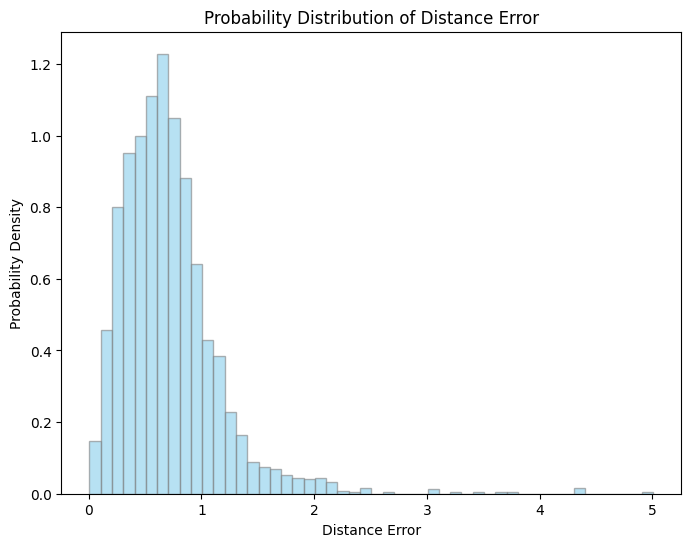

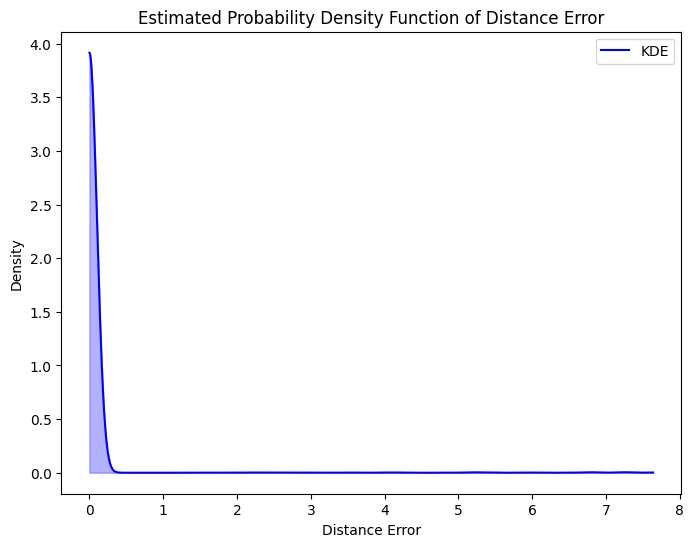

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_individual_errors(y_true, y_pred, coord_dict):
    """
    y_true: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂ≠òÊîæÁúüÂØ¶ÁöÑÊ®ôÁ±§ (0-indexÔºåÂ¶Ç 0~48)
    y_pred: ‰∫åÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂΩ¢ÁãÄ (N,2)ÔºåÂ≠òÊîæÂõûÊ≠∏Ëº∏Âá∫ÁöÑ (X, Y)
    coord_dict: dictÔºåÂ∞áÊ®ôÁ±§Ôºà1~49ÔºâËΩâÊèõÁÇ∫ (X, Y) Â∫ßÊ®ô
    """
    errors = []
    for true_label, pred_coord in zip(y_true, y_pred):
        # Â∞á 0-index ËΩâÊèõÊàê 1-index (‰æãÂ¶Ç 0 -> 1, 48 -> 49)
        true_label = int(true_label) + 1  
        if true_label not in coord_dict:
            continue
        true_coord = np.array(coord_dict[true_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.array(errors)

# ÂÅáË®≠ all_labels ÁÇ∫ÁúüÂØ¶ÂàÜÈ°ûÊ®ôÁ±§ (0-index)Ôºåall_reg ÁÇ∫Ê®°ÂûãÂõûÊ≠∏Ëº∏Âá∫ÁöÑ (X, Y) Â∫ßÊ®ô (NumPy Èô£Âàó)
errors1 = compute_individual_errors(np.array(all_labels), np.array(all_reg), COORDINATES)

# Áπ™Ë£ΩÁõ¥ÊñπÂúñ (Ê≠∏‰∏ÄÂåñÁÇ∫Ê©üÁéáÂØÜÂ∫¶)
plt.figure(figsize=(8,6))
plt.hist(errors1, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
plt.xlabel('Distance Error')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of Distance Error')
plt.show()

# ‰ΩøÁî® Gaussian KDE ‰º∞Ë®àÂØÜÂ∫¶
kde = gaussian_kde(errors)
x_range = np.linspace(0, errors.max(), 1000)
density = kde(x_range)

plt.figure(figsize=(8,6))
plt.plot(x_range, density, 'b-', label='KDE')
plt.fill_between(x_range, density, alpha=0.3, color='blue')
plt.xlabel('Distance Error')
plt.ylabel('Density')
plt.title('Estimated Probability Density Function of Distance Error')
plt.legend()
plt.show()


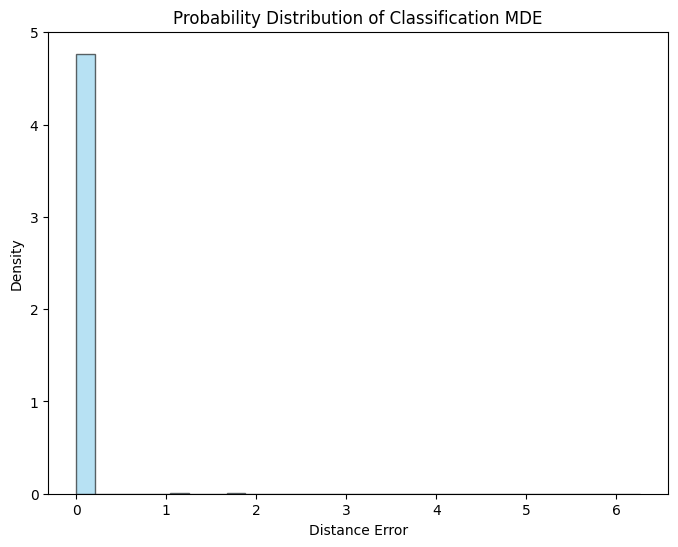

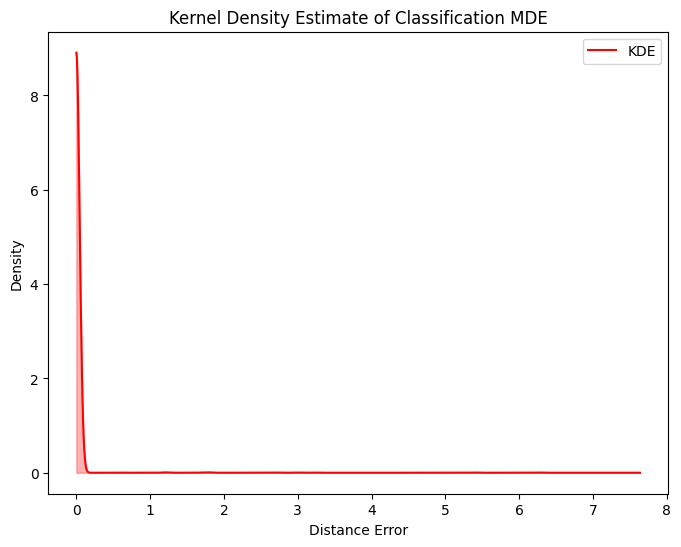

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_individual_errors_cls(y_true, y_pred, coordinates):
    """
    y_true, y_pred: ‰∏ÄÁ∂≠ÁöÑ NumPy Èô£ÂàóÔºåÂàÜÂà•Â≠òÊîæÁúüÂØ¶ÂíåÈ†êÊ∏¨ÁöÑ labelÔºàÊï¥Êï∏Ôºâ
    coordinates: dict, label -> (x, y)
    """
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        # Ëã•ÊüêÂÄãÊ®ôÁ±§‰∏çÂú®Â≠óÂÖ∏‰∏≠ÔºåÂ∞±Ë∑≥ÈÅé
        if true_label not in coordinates or pred_label not in coordinates:
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.array(errors)

# Ë®àÁÆóÊØèÁ≠ÜË≥áÊñôÁöÑË∑ùÈõ¢Ë™§Â∑Æ
errors1 = compute_individual_errors_cls(np.array(all_labels), np.array(all_predictions), COORDINATES)

# Áπ™Ë£ΩÁõ¥ÊñπÂúñÔºåË®≠ÁΩÆ density=True ‰ΩøÁõ¥ÊñπÂúñÊ≠∏‰∏ÄÂåñÁÇ∫Ê©üÁéáÂØÜÂ∫¶
plt.figure(figsize=(8,6))
plt.hist(errors1, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.xlabel("Distance Error")
plt.ylabel("Density")
plt.title("Probability Distribution of Classification MDE")
plt.show()

# ‰ΩøÁî® Gaussian KDE ‰º∞Ë®àÂØÜÂ∫¶‰∏¶Áπ™Ë£Ω
kde = gaussian_kde(errors1)
x_range = np.linspace(0, errors.max(), 1000)
density = kde(x_range)

plt.figure(figsize=(8,6))
plt.plot(x_range, density, 'r-', label="KDE")
plt.fill_between(x_range, density, alpha=0.3, color='red')
plt.xlabel("Distance Error")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Classification MDE")
plt.legend()
plt.show()


In [277]:
sorted_errors = np.sort(errors1)

for error in sorted_errors:
    if error > 0:
        print(error.round(4))

0.6
1.2
1.2
1.6971
1.8
1.8
2.6833
3.0
3.2311
5.4
6.2642


/tmp/ipykernel_64903/2850556480.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Method", y="Error", data=df_baseline, width=0.4, palette={"Baseline": "lightcoral"}, flierprops=flierprops_baseline)
/tmp/ipykernel_64903/2850556480.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Method", y="Error", data=df_improved, width=0.4, palette={"Improved": "skyblue"}, flierprops=flierprops_improved)


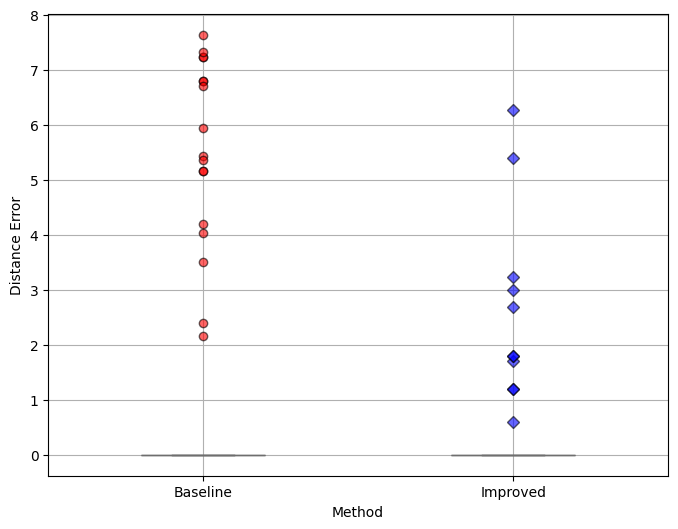

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Âª∫Á´ã DataFrame
df_baseline = pd.DataFrame({"Method": ["Baseline"] * len(errors), "Error": errors})
df_improved = pd.DataFrame({"Method": ["Improved"] * len(errors1), "Error": errors1})

# Ë®≠ÂÆöÈ°èËâ≤
palette = {"Baseline": "lightcoral", "Improved": "skyblue"}

# Ë®≠ÂÆöÁï∞Â∏∏ÈªûÊ®£Âºè
flierprops_baseline = {"marker": "o", "markersize": 6, "markerfacecolor": "red", "markeredgecolor": "black", "alpha": 0.6}
flierprops_improved = {"marker": "D", "markersize": 6, "markerfacecolor": "blue", "markeredgecolor": "black", "alpha": 0.6}

# Áπ™Ë£ΩÁÆ±ÂûãÂúñ
plt.figure(figsize=(8,6))

# ÂàÜÈñãÁπ™Ë£ΩÂÖ©ÂÄãÁÆ±ÂûãÂúñÔºå‰ª•Á¢∫‰øù‰∏çÂêåÁï∞Â∏∏ÈªûÊ®£Âºè
sns.boxplot(x="Method", y="Error", data=df_baseline, width=0.4, palette={"Baseline": "lightcoral"}, flierprops=flierprops_baseline)
sns.boxplot(x="Method", y="Error", data=df_improved, width=0.4, palette={"Improved": "skyblue"}, flierprops=flierprops_improved)

# Ë®≠ÂÆöÊ®ôÁ±§
plt.ylabel("Distance Error")
plt.grid(True)

# È°ØÁ§∫ÂúñÂΩ¢
plt.show()





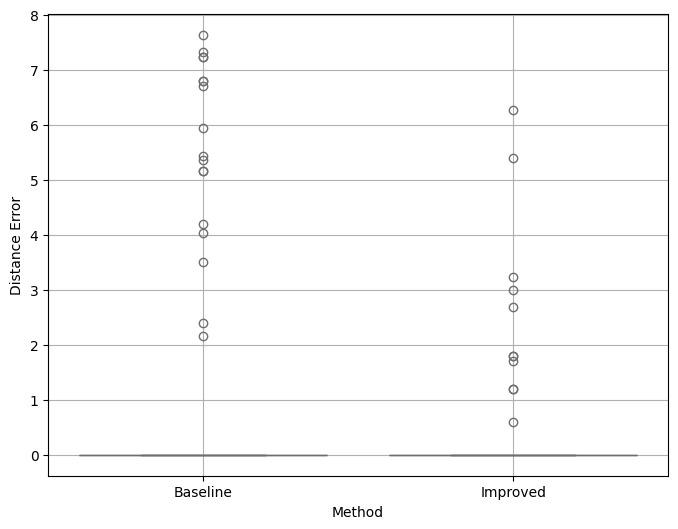

In [284]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Âª∫Á´ã DataFrame
df = pd.DataFrame({
    "Method": ["Baseline"] * len(errors) + ["Improved"] * len(errors1),
    "Error": np.concatenate([errors, errors1])
})

# ‰øÆÊ≠£ `palette` ÁÇ∫Â≠óÂÖ∏Â∞çÊáâÈ°èËâ≤
palette = {"Baseline": "lightcoral", "Improved": "skyblue"}

# Áπ™Ë£ΩÁÆ±ÂûãÂúñ
plt.figure(figsize=(8,6))
sns.boxplot(x="Method", y="Error", data=df, hue="Method", palette=palette)

# Ë®≠ÂÆöÊ®ôÁ±§
plt.ylabel("Distance Error")
plt.grid(True)

# ÁßªÈô§ÈáçË§áÁöÑÂúñ‰æã
plt.legend([],[], frameon=False)

# È°ØÁ§∫ÂúñÂΩ¢
plt.show()
